In [22]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day
from evaluation import Referee

os.environ['DATA_DIR'] = '../data/'
os.environ['SUB_DIR'] = '../submissions/'

# Baseline for M5Forecast - Accuracy
This notebook calculates the mean of the final $k$ training days to create a very basic baseline. 

In [23]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# select true sales period
sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

# create referee with true sales
ref = Referee(sales_true, sales_train, sell_prices, calendar)

  0%|          | 0/28 [00:00<?, ?it/s]

Converting sales to money spent...


100%|██████████| 28/28 [04:49<00:00, 10.33s/it]


Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [24]:
metrics_list = []
k_options = range(2, 56+1, 2)

for k in tqdm(k_options):
    # create skeleton for predictions
    sales_pred = sales_true.copy()
    day_cols = sales_pred.filter(regex='d_').columns
    sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

    # set all predictions to training mean of last k days
    for dday in day_cols:
        df = select_dates(sales_train, num_days=k, day_end=select_final_day(sales_train))
        sales_pred[dday] = df.filter(regex='d_').mean(axis=1)

    # evaluate predictions
    metrics = ref.evaluate(sales_pred)
    # print(metrics)
    metrics_list.append(metrics)

100%|██████████| 28/28 [01:46<00:00,  3.79s/it]


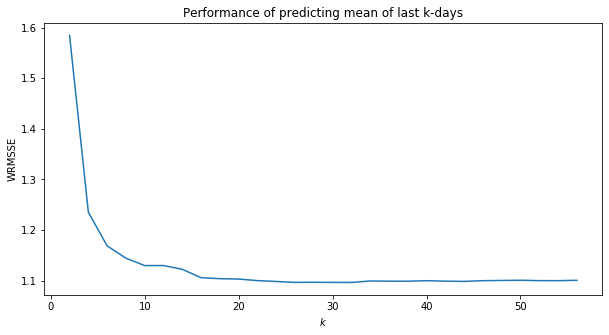

In [25]:
WRMSSE_list = [m['WRMSSE'] for m in metrics_list]

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(k_options, WRMSSE_list)
ax.set_xlabel('$k$'); ax.set_ylabel('WRMSSE')
ax.set_title("Performance of predicting mean of last k-days")
plt.show()

In [26]:
np.min(WRMSSE_list), k_options[np.argmin(WRMSSE_list)]

(1.0967277003658602, 32)

**Result**: Using the mean of the final 20-40 days performed best. 

In [27]:
# Re-calculate predictions with k=30
k = 30

sales_pred = sales_true.copy()
day_cols = sales_pred.filter(regex='d_').columns
sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

# set all predictions to training mean of last k days
for dday in tqdm(day_cols, desc='calculating means'):
    df = select_dates(sales_train, num_days=k, day_end=select_final_day(sales_train))
    sales_pred[dday] = df.filter(regex='d_').mean(axis=1)

calculating means: 100%|██████████| 28/28 [00:00<00:00, 36.77it/s]


## Create submission

In [29]:
create_submission(sales_pred,filename='kmeans',add_timestamp=False)

Submit the predictions using:

`kaggle competitions submit -c m5-forecasting-accuracy -f submissions/submission_kmean.csv -m "Mean final 30 days"`